<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [4]:
data = pd.read_csv('/content/drive/MyDrive/dls/train.csv')

In [5]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [6]:
data

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0


In [7]:
non = [data[name_col].isna().sum() for name_col in data.columns]

In [8]:
df = pd.DataFrame({'name': data.columns, 'nan_amount': non})

In [9]:
df

,name,nan_amount
0,ClientPeriod,0
1,MonthlySpending,0
2,TotalSpent,0
3,Sex,0
4,IsSeniorCitizen,0
5,HasPartner,0
6,HasChild,0
7,HasPhoneService,0
8,HasMultiplePhoneNumbers,0
9,HasInternetService,0


NaN значений в наборе данных нет

Проверим есть ли дубликаты строк

In [10]:
data.duplicated().sum()

14

Удалим дубликаты

In [11]:
data = data.drop_duplicates().reset_index(drop=True)

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

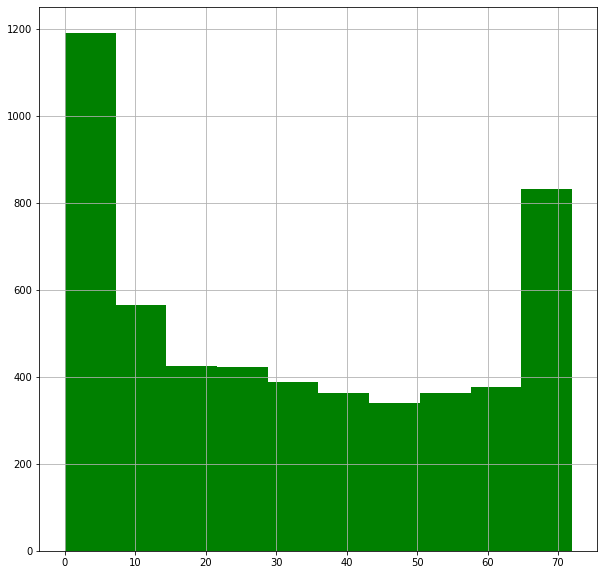

In [12]:
data[num_cols[0]].hist(figsize=(10, 10), color='green');

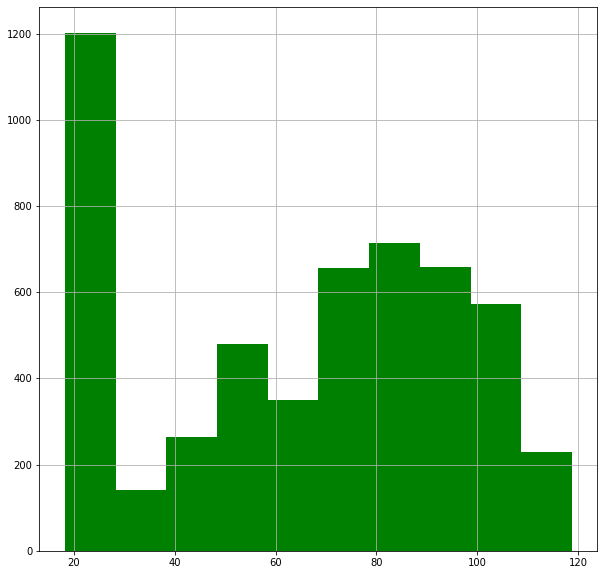

In [13]:
data[num_cols[1]].hist(figsize=(10, 10), color='green');

При попытке визуализировать данные колонки TotalSpent происходит ошибка. 
Сейчас мы попытаемся разобраться в этом. 

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5268 non-null   object 
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnlin

TotalSpent имеет тип object, а не float и int как две другие колонки. Поэксперементируем с этим в следующем блоке.

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [15]:
data.query('TotalSpent == ""')

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn


Пустых значений нет

In [16]:
data.query('TotalSpent == " "')

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1704,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2538,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3070,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3688,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
3992,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4315,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4538,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4585,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Но есть строки где вместо числового значения стоит пробел " ".

In [17]:
data[(data['TotalSpent'] == " ")]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1704,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2538,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3070,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3688,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
3992,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4315,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4538,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4585,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Таких строк 9 штук. Удалим их из набора данных.

In [18]:
data.shape

(5268, 20)

In [19]:
data_mod = data.drop(data[data['TotalSpent'] == " "].index)

In [20]:
data_mod.shape

(5259, 20)

Посмотрим информацию о данных ещё раз.

In [21]:
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5259 entries, 0 to 5267
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5259 non-null   int64  
 1   MonthlySpending           5259 non-null   float64
 2   TotalSpent                5259 non-null   object 
 3   Sex                       5259 non-null   object 
 4   IsSeniorCitizen           5259 non-null   int64  
 5   HasPartner                5259 non-null   object 
 6   HasChild                  5259 non-null   object 
 7   HasPhoneService           5259 non-null   object 
 8   HasMultiplePhoneNumbers   5259 non-null   object 
 9   HasInternetService        5259 non-null   object 
 10  HasOnlineSecurityService  5259 non-null   object 
 11  HasOnlineBackup           5259 non-null   object 
 12  HasDeviceProtection       5259 non-null   object 
 13  HasTechSupportAccess      5259 non-null   object 
 14  HasOnlin

Колонка TotalSpent всё ещё принадлежит к типу object. Приведём её к числовому типу.

In [22]:
data_mod['TotalSpent'] = pd.to_numeric(data_mod['TotalSpent'])

In [23]:
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5259 entries, 0 to 5267
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5259 non-null   int64  
 1   MonthlySpending           5259 non-null   float64
 2   TotalSpent                5259 non-null   float64
 3   Sex                       5259 non-null   object 
 4   IsSeniorCitizen           5259 non-null   int64  
 5   HasPartner                5259 non-null   object 
 6   HasChild                  5259 non-null   object 
 7   HasPhoneService           5259 non-null   object 
 8   HasMultiplePhoneNumbers   5259 non-null   object 
 9   HasInternetService        5259 non-null   object 
 10  HasOnlineSecurityService  5259 non-null   object 
 11  HasOnlineBackup           5259 non-null   object 
 12  HasDeviceProtection       5259 non-null   object 
 13  HasTechSupportAccess      5259 non-null   object 
 14  HasOnlin

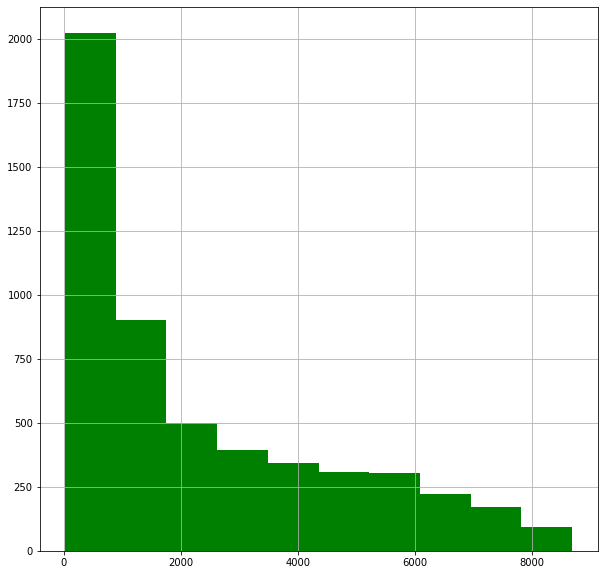

In [24]:
data_mod[num_cols[2]].hist(figsize=(10, 10), color='green');

Продолжим построение графиков, теперь для категориальных признаков.

In [25]:
import seaborn as sns

In [57]:
data_mod[target_col].value_counts()

0    3885
1    1374
Name: Churn, dtype: int64

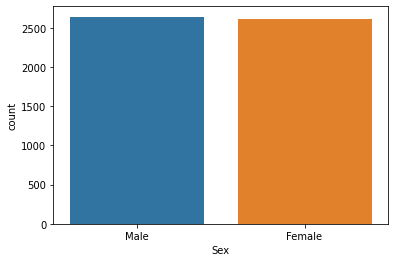

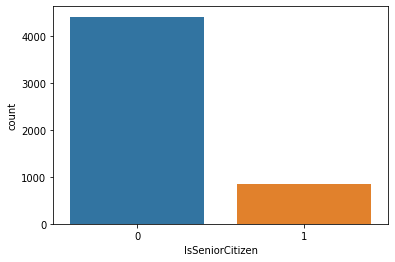

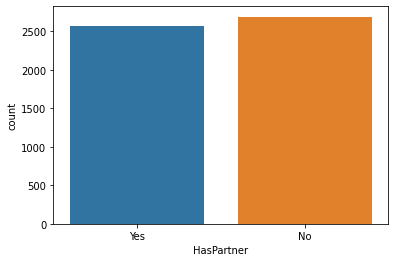

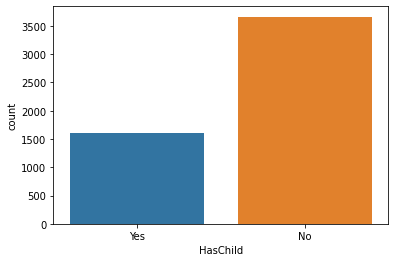

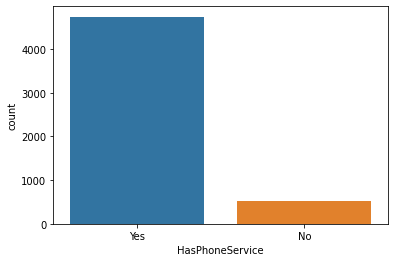

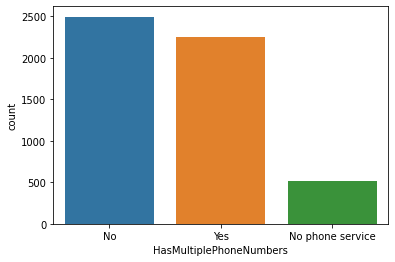

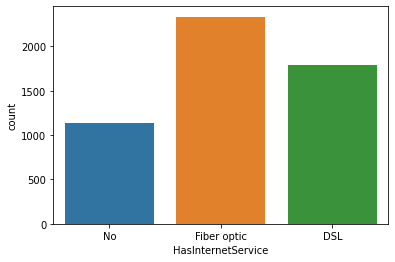

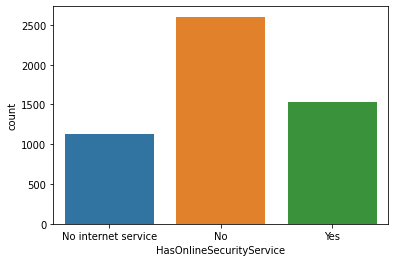

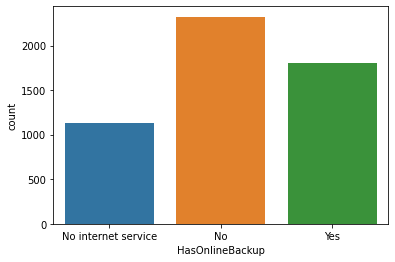

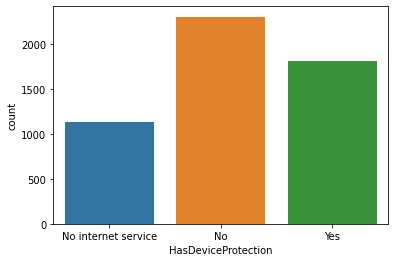

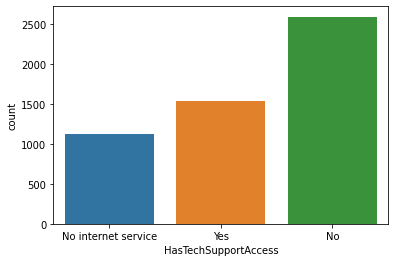

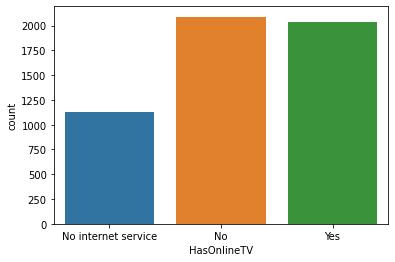

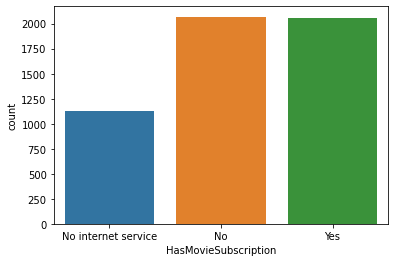

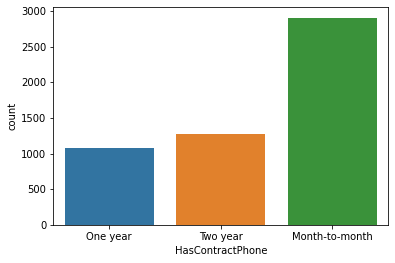

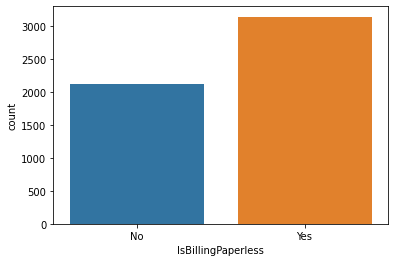

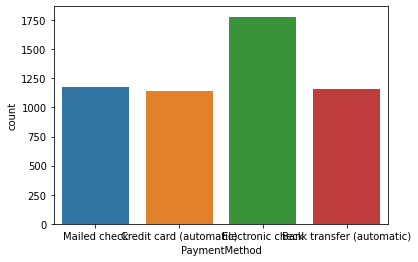

In [58]:
for i in range(len(cat_cols)):
  sns.countplot(data=data_mod, x=cat_cols[i]);
  plt.show()

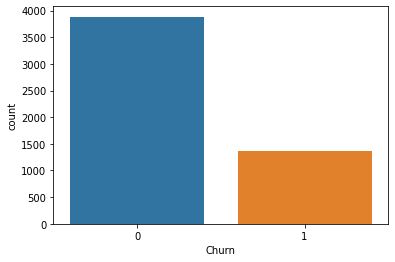

In [59]:
sns.countplot(data=data_mod, x=target_col);

In [60]:
data_mod[target_col].value_counts()

0    3885
1    1374
Name: Churn, dtype: int64

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [61]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

In [66]:
numeric_data = data_mod[num_cols]

In [67]:
categorial_data = data_mod[cat_cols]

In [68]:
encoding_features = pd.get_dummies(categorial_data)

In [69]:
X = pd.concat([numeric_data, encoding_features], axis=1)

In [70]:
y = data_mod[target_col]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.8, random_state=42)

In [76]:
log_reg = make_pipeline(StandardScaler(), LogisticRegression())
param_grid = {'logisticregression__C': np.array([100, 10, 1, 0.1, 0.01, 0.001])}
search = GridSearchCV(log_reg, param_grid, n_jobs=-1, cv=5, refit=True, scoring='roc_auc')
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_clas

In [77]:
print(search.best_params_)

{'logisticregression__C': 1.0}


In [78]:
print(search.best_score_)

0.8430872249666079


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [ ]:
# YOUR CODE

In [39]:
!pip3 install catboost

     |████████████████████████████████| 76.4 MB 23 kB/s 


In [40]:
from catboost import CatBoostClassifier

In [80]:
parametrs = {
    'iterations': range(100, 201, 50),
    'min_data_in_leaf': range(50, 61, 10),
    'depth': range(5, 8),
    'l2_leaf_reg': range(2, 4)    
}

clf = CatBoostClassifier(
                         eval_metric='AUC:hints=skip_train~false',
                         cat_features=cat_cols, 
                         random_state=42,
                         loss_function='Logloss',
                         learning_rate=0.1   
)

catboost_result = clf.grid_search(parametrs, data[num_cols + cat_cols], data[target_col])

Выходные данные были обрезаны до нескольких последних строк (5000).
56:	learn: 0.8692097	test: 0.8606559	best: 0.8631626 (25)	total: 443ms	remaining: 723ms
57:	learn: 0.8694890	test: 0.8606325	best: 0.8631626 (25)	total: 451ms	remaining: 715ms
58:	learn: 0.8701532	test: 0.8607866	best: 0.8631626 (25)	total: 458ms	remaining: 707ms
59:	learn: 0.8710015	test: 0.8604131	best: 0.8631626 (25)	total: 466ms	remaining: 699ms
60:	learn: 0.8710719	test: 0.8603711	best: 0.8631626 (25)	total: 472ms	remaining: 688ms
61:	learn: 0.8715378	test: 0.8604318	best: 0.8631626 (25)	total: 479ms	remaining: 680ms
62:	learn: 0.8721933	test: 0.8598810	best: 0.8631626 (25)	total: 487ms	remaining: 672ms
63:	learn: 0.8721916	test: 0.8598856	best: 0.8631626 (25)	total: 492ms	remaining: 660ms
64:	learn: 0.8728085	test: 0.8596102	best: 0.8631626 (25)	total: 499ms	remaining: 653ms
65:	learn: 0.8729372	test: 0.8599650	best: 0.8631626 (25)	total: 506ms	remaining: 645ms
66:	learn: 0.8734564	test: 0.8599183	best: 0.8631626

In [ ]:
print(catboost_result['params'])
print(clf.get_best_score())

{'min_data_in_leaf': 50, 'depth': 7, 'l2_leaf_reg': 4, 'iterations': 200}
{'learn': {'Logloss': 0.3097793157259848, 'AUC': 0.9291277066423244}}


In [91]:
best_model = CatBoostClassifier(
                         eval_metric='AUC:hints=skip_train~false', 
                         cat_features=cat_cols, 
                         random_state=42,
                         iterations=200,
                         l2_leaf_reg=2,
                         min_data_in_leaf = 50,
                         depth=8)  # модель с лучшими параметрами из предыдущего шага
best_model.fit(data[num_cols + cat_cols], data[target_col]) 

0:	learn: 0.8179917	total: 30.1ms	remaining: 5.99s
1:	learn: 0.8359247	total: 60.7ms	remaining: 6.01s
2:	learn: 0.8375783	total: 76.4ms	remaining: 5.02s
3:	learn: 0.8439397	total: 109ms	remaining: 5.35s
4:	learn: 0.8451166	total: 150ms	remaining: 5.84s
5:	learn: 0.8463007	total: 171ms	remaining: 5.51s
6:	learn: 0.8483646	total: 199ms	remaining: 5.5s
7:	learn: 0.8476408	total: 215ms	remaining: 5.15s
8:	learn: 0.8487265	total: 248ms	remaining: 5.26s
9:	learn: 0.8485402	total: 264ms	remaining: 5.02s
10:	learn: 0.8498491	total: 303ms	remaining: 5.21s
11:	learn: 0.8502074	total: 335ms	remaining: 5.24s
12:	learn: 0.8502720	total: 363ms	remaining: 5.22s
13:	learn: 0.8515684	total: 392ms	remaining: 5.2s
14:	learn: 0.8517103	total: 409ms	remaining: 5.04s
15:	learn: 0.8528565	total: 437ms	remaining: 5.02s
16:	learn: 0.8532306	total: 464ms	remaining: 5s
17:	learn: 0.8534065	total: 490ms	remaining: 4.95s
18:	learn: 0.8537701	total: 516ms	remaining: 4.92s
19:	learn: 0.8548925	total: 546ms	remaining

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Предсказания

In [92]:
X_test = pd.read_csv('/content/drive/MyDrive/dls/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dls/submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:, 1] #/ best_model.predict(X_test)
submission.to_csv('/content/drive/MyDrive/dls/my_submission_3.csv', index=False, columns=["Id", "Churn"])

С помощью подбора параметеров и grid_search итоговая точность составила 0.85216

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.